In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import jax / jnp

import jax
import jax.numpy as jnp

In [3]:
from flox.util import key_chain

# ensure consistent PRNG keys
chain = key_chain(42)

2022-12-01 17:57:34.973559: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.2/lib64
2022-12-01 17:57:34.973640: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.2/lib64
2022-12-01 17:57:34.973647: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [4]:
from jax import Array

# dataclasses that can be used as pytrees in vmap/tree_map etc.
from jax_dataclasses import pytree_dataclass


@pytree_dataclass(frozen=True)
class Box:
    """
    Simulation box.

    Args:
        max: maximum corner of the box
        min: minimum corner of the box
            defaults to (0, 0, 0)
    """

    max: jnp.ndarray
    min: jnp.ndarray = jnp.zeros(3)

    @property
    def size(self):
        return self.max - self.min

@pytree_dataclass
class State:
    """
    State being passed through the flow.
    
    Args:
        rot: quaternion describing current rotation
        pos: 3D vector describing current position
        ics: internal DoF of the system
        aux: auxiliary state
        box: simulation box
    """

    rot: Array
    pos: Array
    ics: tuple[Array, ...]
    aux: Array
    box: Box

### Neural Networks used for the flows

In [5]:
from functools import partial

# nn library
import equinox as eqx

# typing information
from jaxtyping import Float, Array  # type: ignore

from flox._src.nn.modules import dense
from flox.flow import Transformed

# purely functional handling of dataclasses
import lenses

KeyArray = jnp.ndarray | jax.random.PRNGKeyArray

class QuatEncoder(eqx.Module):
    """Encodes a quaternion into a flip-invariant representation."""
    encoder: eqx.nn.Linear

    def __init__(self, num_out: int, *, key: KeyArray):
        """Encodes a quaternion into a flip-invariant representation.

        Args:
            num_out (int): number of dimensions of output representation.
            key (KeyArray): PRNG Key for layer initialization
        """
        self.encoder = eqx.nn.Linear(4, num_out + 1, key=key)

    def __call__(self, quat: Float[Array, "... num_mols 4"]) -> Float[Array, "... num_mols 4"]:
        inp = jnp.stack([quat, -quat])
        out = jax.vmap(jax.vmap(self.encoder))(inp)
        weight = jax.nn.softmax(out[..., 0], axis=0)
        return (weight[..., None] * out[..., 1:]).sum(axis=0)


class Transformer(eqx.Module):
    """Standard impl of a transformer according to the `attention is all you need` paper."""

    attention_1: eqx.nn.MultiheadAttention
    attention_2: eqx.nn.MultiheadAttention

    norm_1: eqx.nn.LayerNorm
    norm_2: eqx.nn.LayerNorm
    norm_3: eqx.nn.LayerNorm

    dense: eqx.nn.Sequential

    def __init__(self, num_heads: int, num_dims: int, num_hidden: int, *, key: KeyArray):
        """Standard impl of a transformer according to the `attention is all you need` paper."

        Args:
            num_heads (int): number of transformer heads
            num_dims (int): node dimensionality
            num_hidden (int): hidden dimension of final dense layer
            key (KeyArray): PRNG Key for layer initialization
        """

        self.attention_1 = eqx.nn.MultiheadAttention(
            num_heads,
            num_dims * num_heads,
            use_key_bias=True,
            use_query_bias=False,
            use_output_bias=True,
            key=next(chain)
        )

        self.attention_2 = eqx.nn.MultiheadAttention(
            num_heads,
            num_dims * num_heads,
            use_key_bias=True,
            use_query_bias=False,
            use_output_bias=True,
            key=next(chain)
        )

        self.norm_1 = eqx.nn.LayerNorm(
            shape=(num_dims * num_heads),
            elementwise_affine=True)

        self.norm_2 = eqx.nn.LayerNorm(
            shape=(num_dims * num_heads),
            elementwise_affine=True)

        self.norm_3 = eqx.nn.LayerNorm(
            shape=(num_dims * num_heads),
            elementwise_affine=True)

        self.dense = dense(
            (num_dims * num_heads, num_hidden, num_dims * num_heads),
            jax.nn.silu,
            key=next(chain)
        )

    def __call__(self, input: Float[Array, "... seq_len node_dim"]) -> Float[Array, "... seq_len node_dim"]:

        input += self.attention_1(input, input, input)
        input = jax.vmap(self.norm_1)(input)

        input += self.attention_2(input, input, input)
        input = jax.vmap(self.norm_2)(input)

        input += jax.vmap(self.dense)(input)
        input = jax.vmap(self.norm_3)(input)

        return input        


class TransformerStack(eqx.Module):
    """Stack of transformer layers.

       DISCLAIMER: right now only implements a simple dense net!!!!
    """

    encoder: eqx.nn.Linear
    decoder: eqx.nn.Linear

    transformers: tuple[Transformer]

    # use simple dense net for now as transformers don't work (yet)
    foo: eqx.nn.Sequential

    def __init__(self, num_inp: int, num_out: int, num_heads: int, num_dims: int, num_hidden: int, num_blocks: int=0, *, key: KeyArray):
        chain = key_chain(key)
        self.encoder = eqx.nn.Linear(num_inp, num_heads * num_dims, key=next(chain))
        self.transformers = tuple(
            Transformer(num_heads, num_dims, num_hidden, key=next(chain))
            for _ in range(num_blocks)
        )
        self.decoder = eqx.nn.Linear(num_heads * num_dims, num_out, key=next(chain))

        self.foo = dense(
            (num_inp * 16, num_hidden, num_hidden, num_out * 16),
            jax.nn.silu,
            key=next(chain)
        )

    def __call__(self, input: Float[Array, "... seq_len node_dim"]) -> Float[Array, "... seq_len node_dim"]:
        return self.foo(input.reshape(-1)).reshape(input.shape[0], -1)
        input = jax.vmap(self.encoder)(input)
        for transformer in self.transformers:
            input = transformer(input)
        
        return jax.vmap(self.decoder)(input)



### Flow layers

In [6]:
from functools import partial
from flox.flow import DoubleMoebius, Affine, Pipe, VectorizedTransform
from flox.util import unpack
from flox import geom

class QuatUpdate(eqx.Module):
    """Flow layer updating the quaternion part of a state"""

    net: TransformerStack

    def __init__(
        self,
        num_aux: int,
        num_pos: int = 3,
        num_rot: int = 4,
        num_heads: int = 4,
        num_dims: int = 64,
        num_hidden: int = 64,
        *, 
        key: KeyArray,
    ):
        """Flow layer updating the quaternion part of a state.

        Args:
            num_aux (int): number of auxiliaries used
            num_pos (int, optional): number of position DoF. Defaults to 3.
            num_rot (int, optional): number of quaternion DoF. Defaults to 4.
            num_heads (int, optional): number of transformer heads. Defaults to 4.
            num_dims (int, optional): node dimension within the transformer stack. Defaults to 64.
            num_hidden (int, optional): hidden dim of transformer. Defaults to 64.
            key (KeyArray): PRNGKey for param initialization
        """
        self.net = TransformerStack(
            num_inp=num_aux + num_pos,
            num_out=num_rot,
            num_heads=num_heads,
            num_dims=num_dims,
            num_hidden=num_hidden,
            key=key
        )

    def params(self, input: State) -> Array:
        """Compute the parameters for the double moebius transform

        Args:
            input (State): current state

        Returns:
            Array: the parameter (reflection) of the double moebius transform
        """
        feats = jnp.concatenate([
            input.aux,
            input.pos
        ], axis=-1)
        out = self.net(feats)
        out = out.reshape(input.rot.shape)
        out = jax.vmap(
            lambda x: x / (1 + geom.norm(x)) * 0.99
        )(out)
        return out

    def forward(self, input: State) -> Transformed[State]:
        """Forward transform"""
        reflection = self.params(input)
        new, ldj = unpack(VectorizedTransform(DoubleMoebius(reflection)).forward(input.rot))
        return Transformed(
            lenses.bind(input).rot.set(new),
            ldj
        )

    def inverse(self, input: State) -> Transformed[State]:
        """Inverse transform"""
        reflection = self.params(input)
        new, ldj = unpack(VectorizedTransform(DoubleMoebius(reflection)).inverse(input.rot))
        return Transformed(
            lenses.bind(input).rot.set(new),
            ldj
        )

class AuxUpdate(eqx.Module):
    """Flow layer updating the auxiliary part of a state"""

    symmetrizer: QuatEncoder
    net: TransformerStack

    def __init__(
        self,
        num_aux: int,
        num_pos: int = 3,
        num_rot: int = 4,
        num_heads: int = 4,
        num_dims: int = 64,
        num_hidden: int = 64,
        *, 
        key: KeyArray,
    ):
        """Flow layer updating the auxiliary part of a state.

        Args:
            num_aux (int): number of auxiliaries used
            num_pos (int, optional): number of position DoF. Defaults to 3.
            num_rot (int, optional): number of quaternion DoF. Defaults to 4.
            num_heads (int, optional): number of transformer heads. Defaults to 4.
            num_dims (int, optional): node dimension within the transformer stack. Defaults to 64.
            num_hidden (int, optional): hidden dim of transformer. Defaults to 64.
            key (KeyArray): PRNGKey for param initialization
        """
        chain = key_chain(key)
        self.symmetrizer = QuatEncoder(num_dims, key=next(chain))
        self.net = TransformerStack(
            num_inp=num_dims + num_pos,
            num_out=2 * num_aux,
            num_heads=num_heads,
            num_dims=num_dims,
            num_hidden=num_hidden,
            key=next(chain)
        )

    def params(self, input: State) -> tuple[Array, Array]:
        """Compute the parameters for the affine transform

        Args:
            input (State): current state

        Returns:
            tuple[Array, Array]: the parameters (shift, scale) of the affine transform
        """
        feats = jnp.concatenate([
            input.pos,
            self.symmetrizer(input.rot)
        ], axis=-1)
        out = self.net(feats)
        out = out.reshape(input.aux.shape[0], -1)
        shift, scale = jnp.split(out, 2, axis=-1)
        scale = scale * 1e-1
        return shift, scale

    def forward(self, input: State) -> Transformed[State]:
        """Forward transform"""
        shift, scale = self.params(input)
        new, ldj = unpack(Affine(shift, scale).forward(input.aux))
        return Transformed(
            lenses.bind(input).aux.set(new),
            ldj
        )

    def inverse(self, input: State) -> Transformed[State]:
        """Inverse transform"""
        shift, scale = self.params(input)
        new, ldj = unpack(Affine(shift, scale).inverse(input.aux))
        return Transformed(
            lenses.bind(input).aux.set(new),
            ldj
        )


class PosUpdate(eqx.Module):
    """Flow layer updating the position part of a state"""

    symmetrizer: QuatEncoder
    net: TransformerStack

    def __init__(
        self,
        num_aux: int,
        num_pos: int = 3,
        num_rot: int = 4,
        num_heads: int = 4,
        num_dims: int = 64,
        num_hidden: int = 64,
        *, 
        key: KeyArray,
    ):
        """Flow layer updating the position part of a state.

        Args:
            num_aux (int): number of auxiliaries used
            num_pos (int, optional): number of position DoF. Defaults to 3.
            num_rot (int, optional): number of quaternion DoF. Defaults to 4.
            num_heads (int, optional): number of transformer heads. Defaults to 4.
            num_dims (int, optional): node dimension within the transformer stack. Defaults to 64.
            num_hidden (int, optional): hidden dim of transformer. Defaults to 64.
            key (KeyArray): PRNGKey for param initialization
        """
        chain = key_chain(key)
        self.symmetrizer = QuatEncoder(num_dims, key=next(chain))
        self.net = TransformerStack(
            num_inp=num_dims + num_aux,
            num_out=2 * num_pos,
            num_heads=num_heads,
            num_dims=num_dims,
            num_hidden=num_hidden,
            key=next(chain)
        )

    def params(self, input: State) -> tuple[Array, Array]:
        """Compute the parameters for the affine transform

        Args:
            input (State): current state

        Returns:
            tuple[Array, Array]: the parameters (shift, scale) of the affine transform
        """
        feats = jnp.concatenate([
            input.aux,
            self.symmetrizer(input.rot)
        ], axis=-1)
        out = self.net(feats)
        out = out.reshape(input.pos.shape[0], -1)
        shift, scale = jnp.split(out, 2, axis=-1)
        scale = scale * 1e-1
        return shift, scale

    def forward(self, input: State) -> Transformed[State]:
        """Forward transform"""
        shift, scale = self.params(input)
        new, ldj = unpack(Affine(shift, scale).forward(input.pos))
        return Transformed(
            lenses.bind(input).pos.set(new),
            ldj
        )

    def inverse(self, input: State) -> Transformed[State]:
        """Inverse transform"""
        shift, scale = self.params(input)
        new, ldj = unpack(Affine(shift, scale).inverse(input.pos))
        return Transformed(
            lenses.bind(input).pos.set(new),
            ldj
        )


class DisplacementEncoder(eqx.Module):
    """Encodes initial positions within the PBC box into
       displacement vectors relative to centers
       which are predicted from auxiliaries
    """

    symmetrizer: QuatEncoder
    net: TransformerStack

    def __init__(
        self,
        num_aux: int,
        num_pos: int = 3,
        num_rot: int = 4,
        num_heads: int = 4,
        num_dims: int = 64,
        num_hidden: int = 64,
        *, 
        key: KeyArray,
    ):
        """Encodes initial positions within the PBC box into
        displacement vectors relative to centers
        which are predicted from auxiliaries

        Args:
            num_aux (int): number of auxiliaries used
            num_pos (int, optional): number of position DoF. Defaults to 3.
            num_rot (int, optional): number of quaternion DoF. Defaults to 4.
            num_heads (int, optional): number of transformer heads. Defaults to 4.
            num_dims (int, optional): node dimension within the transformer stack. Defaults to 64.
            num_hidden (int, optional): hidden dim of transformer. Defaults to 64.
            key (KeyArray): PRNGKey for param initialization
        """
        chain = key_chain(key)
        self.symmetrizer = QuatEncoder(num_dims, key=next(chain))
        self.net = TransformerStack(
            num_inp=num_aux + num_dims,
            num_out=num_pos,
            num_heads=num_heads,
            num_dims=num_dims,
            num_hidden=num_hidden,
            key=next(chain)
        )

    def params(self, input: State) -> Array:
        """Compute the parameters (centers) given the input state

        Args:
            input (State): current state

        Returns:
            Array: the centers relative to which displacements are computed
        """
        feats = jnp.concatenate([
            input.aux,
            self.symmetrizer(input.rot)
        ], axis=-1)
        out = self.net(feats)
        center = out.reshape(input.pos.shape)
        center = jax.nn.sigmoid(center) * input.box.size
        return center

    def forward(self, input: State) -> Transformed[State]:
        """Forward transform"""
        center = self.params(input)
        diff = geom.Torus(input.box.size).tangent(center, input.pos - center)
        ldj = jnp.zeros(())
        return Transformed(
            lenses.bind(input).pos.set(diff), ldj
        )

    def inverse(self, input: State) -> Transformed[State]:
        """Inverse transform"""
        center = self.params(input)
        ldj = jnp.zeros(())
        pos = geom.Torus(input.box.size).shift(center, input.pos)    
        return Transformed(
            lenses.bind(input).pos.set(pos), ldj
        )

### priors

In [7]:
# a lot of useful standard densities implemented in JAX
import tensorflow_probability.substrates.jax as tfp  # type: ignore

# number
NUM_MOLECULES = 16
NUM_AUXILIARIES = 5

# params of the rotation prior (VMF)
base_rot_means = jnp.tile(jnp.array([1., 0., 0., 0.])[None], (NUM_MOLECULES, 1))
base_rot_concentration = jnp.ones((NUM_MOLECULES,)) * 20

# params of the auxilary prior (normal)
base_aux_means = jnp.zeros((NUM_MOLECULES, NUM_AUXILIARIES))
base_aux_stds = jnp.ones((NUM_MOLECULES, NUM_AUXILIARIES))

# params of the position / displacement prior (normal)
base_pos_means = jnp.zeros((NUM_MOLECULES, 3))
base_pos_stds = jnp.ones((NUM_MOLECULES, 3))

rot_sampler = tfp.distributions.VonMisesFisher(
        base_rot_means, base_rot_concentration
    )
pos_sampler = tfp.distributions.Normal(
    base_pos_means, base_pos_stds
)
aux_sampler = tfp.distributions.Normal(
    base_aux_means, base_aux_stds
)

def base_sampler(key: KeyArray, box: Box) -> Transformed[State]:
    """Samples from the base density

    Args:
        key (KeyArray): PRNG Key
        box (Box): simulation box

    Returns:
        Transformed[State]: a state sampled from the prior density
    """
    chain = key_chain(key)
    
    rot = rot_sampler.sample(seed=next(chain))
    rot = rot * jnp.sign(jax.random.normal(next(chain), shape=(rot.shape[0], 1)))
    pos = pos_sampler.sample(seed=next(chain))
    ics = (jnp.full(shape=(pos.shape[0],), fill_value=0.09572),
           jnp.full(shape=(pos.shape[0],), fill_value=0.09572),
           jnp.full(shape=(pos.shape[0],), fill_value=1.824218))
    aux = aux_sampler.sample(seed=next(chain))
    state = State(rot, pos, ics, aux, box)
    log_prob = base_density(state)
    return Transformed(state, log_prob)


def base_density(inp: State) -> Array:
    """Evaluate the base density for a state

    Args:
        state (State): the state to be evaluated

    Returns:
        Array: the energy of the state
    """
    # symmetrize latent distribution over rotations
    rot_prob = jax.nn.logsumexp(
        jnp.stack([
            rot_sampler.log_prob(inp.rot),
            rot_sampler.log_prob(-inp.rot)
        ]),
        axis=0
    ).sum()
    pos_prob = pos_sampler.log_prob(inp.pos).sum()
    aux_prob = aux_sampler.log_prob(inp.aux).sum()
    return -(rot_prob + aux_prob + pos_prob)



### load data

In [8]:
import numpy as np
from data.water.watermodel import WaterModel

temp = 100
ice_type = 'XI'
n_waters = 16

# path = ''
path = '/group/ag_cmb/scratch/minvernizzi/so3-flow/ice_MDdata/'
info = f'ice{ice_type}_T{temp}_N{n_waters}'
model = WaterModel.load_from_json(f'{path}model-{info}.json')
raw = np.load(f'{path}MDtraj-{info}.npz')

In [9]:



from jaxtyping import Float, Array  # type: ignore
from dataclasses import astuple
import flox

from flox.flow import Lambda, Transform
from flox._src.flow import rigid

Scalar = Float[Array, ""] | float
Vector3 = Float[Array, "... 3"]
Quaternion = Float[Array, "... 4"]
Auxiliary = Float[Array, f"... AUX"]

AtomRepresentation = Float[Array, "... MOL 4 3"]


@pytree_dataclass(frozen=True)
class Data:
    """Raw data format."""
    positions: jnp.ndarray
    box: jnp.ndarray
    energy: jnp.ndarray

data = Data(*map(jnp.array, raw.values()))

@pytree_dataclass(frozen=True)
class AugmentedData:
    """Data augmented with auxilaries and quaternion signs."""
    pos: Array
    aux: Array
    sign: Array
    box: Box


@pytree_dataclass(frozen=True)
class InternalCoordinates:
    d_OH1: Scalar = jnp.array(0.095712)
    d_OH2: Scalar = jnp.array(0.095712)
    a_HOH: Scalar = jnp.array(104.52 * jnp.pi / 180)
    d_OM: Scalar = jnp.array(0.0125)
    a_OM: Scalar = jnp.array(52.259937 * jnp.pi / 180)


@pytree_dataclass(frozen=True)
class RigidRepresentation:
    rot: Quaternion
    pos: Vector3
    ics: InternalCoordinates = InternalCoordinates()


def to_rigid(pos: AtomRepresentation) -> Transformed[RigidRepresentation]:
    q, p, *_ = rigid.from_euclidean(pos[:3])
    ldj = rigid.from_euclidean_log_jacobian(pos[:3])
    return Transformed(RigidRepresentation(q, p), ldj)


def from_rigid(rp: RigidRepresentation) -> Transformed[AtomRepresentation]:
    r_OM = rp.ics.d_OM * jnp.array(
        [jnp.sin(rp.ics.a_OM), 0.0, jnp.cos(rp.ics.a_OM)]
    )
    r_OM = flox.geom.qrot3d(rp.rot, r_OM)
    pos = rigid.to_euclidean(rp.rot, rp.pos, *astuple(rp.ics)[:3])
    ldj = rigid.to_euclidean_log_jacobian(rp.rot, rp.pos, *astuple(rp.ics)[:3])
    pos = jnp.concatenate([pos, (pos[0] + r_OM)[None]], axis=0)
    return Transformed(pos, ldj)


class RigidTransform(Transform[AtomRepresentation, RigidRepresentation]):
    def forward(
        self, inp: AtomRepresentation
    ) -> Transformed[RigidRepresentation]:
        return to_rigid(inp)

    def inverse(
        self, inp: RigidRepresentation
    ) -> Transformed[AtomRepresentation]:
        return from_rigid(inp)

### initial transform mapping (augmented) data into a flow state

In [10]:
from flox._src.flow import rigid, Transform

class InitialTransform(Transform[AugmentedData, State]):
    """Initial transform, transforming data into a state."""

    def forward(self, input: AugmentedData) -> Transformed[State]:
        rigid, ldj = unpack(VectorizedTransform(RigidTransform()).forward(input.pos))
        rigid = lenses.bind(rigid).rot.set(rigid.rot * input.sign)
        state = State(
            rigid.rot,
            rigid.pos,
            rigid.ics,
            input.aux,
            input.box
        )
        return Transformed(state, ldj)

    def inverse(self, input: State) -> Transformed[AugmentedData]:
        rigid = jax.vmap(RigidRepresentation)(
            input.rot,
            input.pos
        )
        pos, ldj = unpack(VectorizedTransform(RigidTransform()).inverse(rigid))
        sign = jnp.sign(input.rot[:, (0,)])
        data = AugmentedData(pos, input.aux, sign, input.box)
        return Transformed(data, ldj)

### define target density

In [11]:
def _force_box_vector(box: Array) -> Array:
    """Helper function that ensures box vectors are indeed vectors
       and no diagonal matrices.

    Args:
        box (Array): box vector of shape (3,) or (3, 3)

    Raises:
        ValueError: error if the box shape is neither (3,) or (3,3)

    Returns:
        Array: the box vector in shape (3,)
    """
    if box.shape == (3, 3):
        return jnp.diag(box)
    elif box.shape == (3,):
        return box
    else:
        raise ValueError(f"Cannot handle box of shape {box.shape}")


def target_sampler(key: KeyArray) -> Transformed[AugmentedData]:
    """Samples from the target (data) distribution.

    Auxiliaries are drawn from a standard normal distribution.

    Quaternion signs are drawn from {-1, 1} uniformily random.

    Args:
        key (KeyArray): PRNG Key

    Returns:
        Transformed[AugmentedData]: Sample from the target distribution.
    """
    chain = key_chain(key)
    idx = jax.random.randint(next(chain), minval=0, maxval=len(data.positions), shape=())
    box = Box(_force_box_vector(data.box[idx]))
    pos = data.positions[idx].reshape(-1, 4, 3)
    aux = aux_sampler.sample(seed=next(chain))
    sign = jnp.sign(jax.random.normal(next(chain), shape=(NUM_MOLECULES, 1)))
    return Transformed(AugmentedData(pos, aux, sign, box), jnp.zeros(()))


In [12]:
from typing import Any


def _preprocess(key: KeyArray, num_aux: int) -> Pipe[AugmentedData, State]:
    """The initial blocks handing:

     - mapping augmented data into a state
     - predicting position centers from the auxilaries
     - mapping positions into displacements relative to position centers

    Args:
        key (KeyArray): PRNG key
        num_aux (int): number of auxilaries

    Returns:
        Pipe[AugmentedData, State]: the initial transform
    """
    chain = key_chain(key)
    return Pipe[AugmentedData, State]([
        InitialTransform(),
        AuxUpdate( num_aux, key=next(chain)),
        DisplacementEncoder(num_aux, key=next(chain)),
    ])


def _coupling(key: KeyArray, num_aux: int) -> Pipe[State, State]:
    """Creates a coupling block consisting of:

     - an update to the auxilaries
     - an update to the quaterions
     - an update to the positions

    Args:
        key (KeyArray): PRNG Key
        num_aux (int): number of auxilaries

    Returns:
        Pipe[State, State]: the coupling block
    """
    chain = key_chain(key)
    return Pipe[State, State]([
        AuxUpdate(num_aux, key=next(chain)),
        QuatUpdate(num_aux, key=next(chain)),
        PosUpdate(num_aux, key=next(chain)),
    ])


def _make_flow(key: KeyArray, num_aux: int, num_blocks: int=2) -> Pipe[AugmentedData, State]:
    """Creates the final flow composed of:

     - a preprocessing transformation
     - multiple coupling blokcks

    Args:
        key (KeyArray): PRNG key
        num_aux (int): number of auxilaries
        num_blocks (int, optional): number of coupling blocks. Defaults to 2.

    Returns:
        Pipe[AugmentedData, State]: the final flow
    """
    chain = key_chain(key)
    blocks: list[Transform[Any, Any]] = [_preprocess(next(chain), num_aux)]
    for _ in range(num_blocks):
        blocks.append(_coupling(next(chain), num_aux))
    return Pipe[AugmentedData, State](blocks)


flow = _make_flow(next(chain), NUM_AUXILIARIES)

### Ensure that the flow is indeed invertible

In [13]:
inp = target_sampler(next(chain)).obj
out = flow.forward(inp).obj
back = flow.inverse(out).obj
assert jnp.max(jnp.abs(back.pos % Box(_force_box_vector(data.box[0])).size - inp.pos % Box(_force_box_vector(data.box[0])).size)) < 1e-5

### Setup optimization and sampling

In [14]:
import optax

optim = optax.adam(1e-3)

params, static = eqx.partition(flow, eqx.is_array)  # type: ignore
opt_state = optim.init(params)

In [15]:
from flox._src.nn.train import free_energy_step
from flox.flow import PullbackSampler

# training step (jit compiled)
step = free_energy_step(base_density, optim, target_sampler, 128)

In [16]:
NUM_ITERS = 20_000
PRINT_ITERS = 500

In [49]:
for i in range(NUM_ITERS):
    loss, flow, opt_state = step(next(chain), flow, opt_state)  # type: ignore
    if i % PRINT_ITERS == 0:
        print(f"iter: {i}/{NUM_ITERS}, loss: {loss:.6}")

iter: 0/20000, loss: -263.637
iter: 500/20000, loss: -262.435
iter: 1000/20000, loss: -263.214
iter: 1500/20000, loss: -262.289
iter: 2000/20000, loss: -262.005
iter: 2500/20000, loss: -261.253
iter: 3000/20000, loss: -261.045
iter: 3500/20000, loss: -263.059
iter: 4000/20000, loss: -263.17
iter: 4500/20000, loss: -262.55
iter: 5000/20000, loss: -262.242
iter: 5500/20000, loss: -261.145
iter: 6000/20000, loss: -261.698
iter: 6500/20000, loss: -261.685
iter: 7000/20000, loss: -261.81
iter: 7500/20000, loss: -262.92
iter: 8000/20000, loss: -259.71
iter: 8500/20000, loss: -261.18
iter: 9000/20000, loss: -263.28
iter: 9500/20000, loss: -263.872
iter: 10000/20000, loss: -263.471
iter: 10500/20000, loss: -263.093
iter: 11000/20000, loss: -262.343
iter: 11500/20000, loss: -262.151
iter: 12000/20000, loss: -261.901
iter: 12500/20000, loss: -263.695
iter: 13000/20000, loss: -261.752
iter: 13500/20000, loss: -263.207
iter: 14000/20000, loss: -263.352
iter: 14500/20000, loss: -262.162
iter: 15000

In [50]:
0/0

ZeroDivisionError: division by zero

### sample from data / model / prior

In [51]:
NUM_SAMPLES = 2000

In [52]:
# sample data

orig = jax.vmap(target_sampler)(jax.random.split(next(chain), NUM_SAMPLES))
orig = lenses.bind(orig).obj.pos.set(orig.obj.pos)
q_orig = jax.vmap(InitialTransform().forward)(orig.obj).obj.rot

In [53]:
# sample model

# sampling function (jit compiled)
sample_from_model = jax.jit(jax.vmap(
    PullbackSampler(partial(base_sampler, box=Box(_force_box_vector(data.box[0]))), flow)
))

samples = sample_from_model(jax.random.split(next(chain), NUM_SAMPLES))
q_samples = jax.vmap(InitialTransform().forward)(samples.obj).obj.rot

In [54]:
# sample prior

prior = jax.vmap(partial(base_sampler, box=Box(_force_box_vector(data.box[0]))))(jax.random.split(next(chain), NUM_SAMPLES))
q_prior = prior.obj.rot

### compare positions and rotations

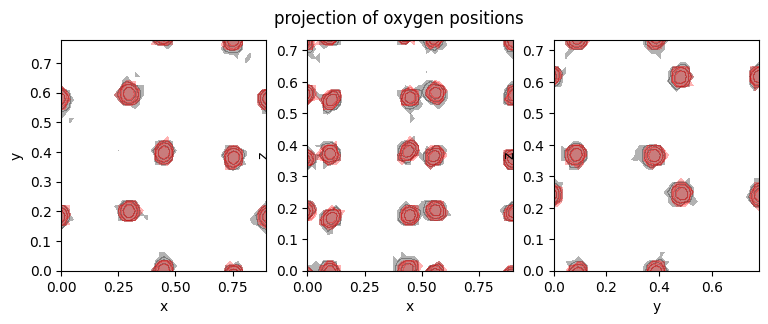

In [55]:
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import itertools as it

box = Box(_force_box_vector(data.box[0]))

def _compute_contour_levels(qi, qj, threshold: float = 1e-5, num_levels: int = 5, num_bins: int = 50) -> tuple[Array, ...]:
    h, *bins = jnp.histogram2d(
            qi,
            qj,
            density=True,
            bins=num_bins + 1
        )
    h = jnp.log(threshold + h)
    levels = jnp.linspace(
        h[h > jnp.log(1e-4)].min(),
        h.max(),
        num_levels
    )
    return h, levels, *bins

def _plot_contour_lines(p, box, dim_i, dim_j, colors: str):
    num_bins = 50
    gx, gy = jnp.meshgrid(
        jnp.linspace(box.min[dim_i], box.max[dim_i], num_bins + 1),
        jnp.linspace(box.min[dim_j], box.max[dim_j], num_bins + 1),
    )
    h, levels, *bins = _compute_contour_levels(
        p[:, :, 0, dim_i].reshape(-1) % box.size[dim_i],
        p[:, :, 0, dim_j].reshape(-1) % box.size[dim_j],
    )
    plt.contourf(gx, gy, h, levels, colors=colors, alpha=0.3, extend="neither", antialiased = False)


plt.figure(figsize=(3 * 3, 1 * 3))
plt.suptitle("projection of oxygen positions")
labels = ("x", "y", "z")
for k, (i, j) in enumerate(it.combinations(range(3), 2), start=1):
    
    plt.subplot(1, 3, k)
    _plot_contour_lines(
        samples.obj.pos,
        Box(_force_box_vector(data.box[0])),
        i, j,
        "black"
    )
    _plot_contour_lines(
        orig.obj.pos,
        Box(_force_box_vector(data.box[0])),
        i, j,
        "red"
    )
    plt.ylabel(labels[j])
    plt.xlabel(labels[i])   


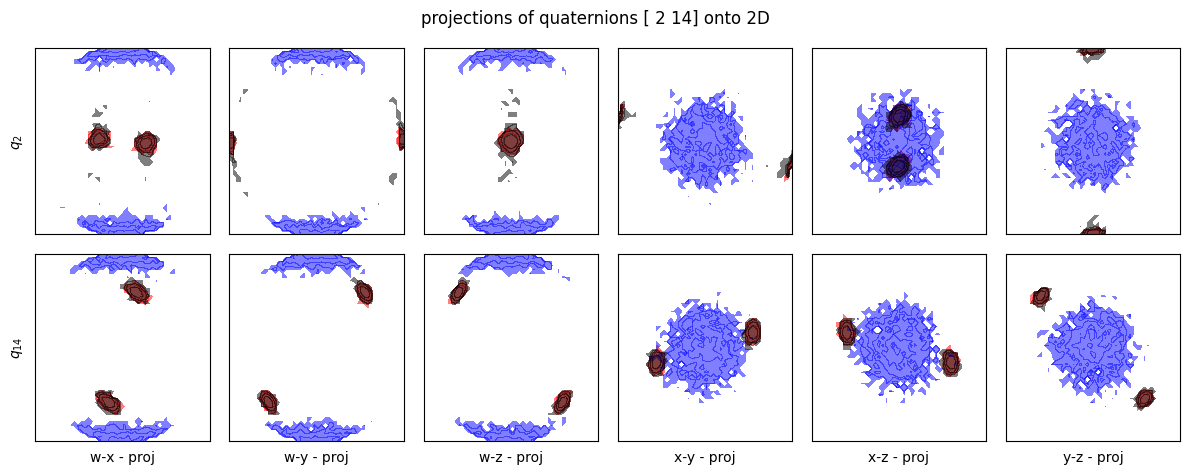

In [56]:
import itertools as it

from matplotlib import pyplot as plt

from matplotlib.colors import LogNorm

NUM_PLOTTED = 2
plt.figure(figsize=(6 * 2, NUM_PLOTTED * 2 + .8))

idx = np.random.randint(16, size=(NUM_PLOTTED,))

plt.suptitle(f"projections of quaternions {idx} onto 2D")

num_bins = 50
gx, gy = jnp.meshgrid(
    jnp.linspace(-1, 1, num_bins),
    jnp.linspace(-1, 1, num_bins)
)

def _compute_contour_levels(qi, qj, threshold: float = 1e-5, num_levels: int = 5, num_bins: int = 50) -> tuple[Array, Array]:
    h, *_ = jnp.histogram2d(
            qi,
            qj,
            density=True,
            bins=(jnp.linspace(-1, 1, num_bins + 1), jnp.linspace(-1, 1, num_bins + 1))  # type: ignore
        )
    h = jnp.log(threshold + h)
    levels = jnp.linspace(
        h[h > jnp.log(1e-4)].min(),
        h.max(),
        num_levels
    )
    return h, levels

def _plot_contour_lines(gx, gy, q, quat_idx, dim_i, dim_j, colors: str):
    h, levels = _compute_contour_levels(
        q[:, quat_idx, dim_i],
        q[:, quat_idx, dim_j]
    )
    plt.contourf(gx, gy, h, levels, colors=colors, alpha=0.5, extend="neither", antialiased = False)

labels = ["w", "x", "y", "z"]

n = 0
for i, (j, k) in it.product(idx, it.combinations(range(4), 2)):
    n = n + 1
    plt.subplot(NUM_PLOTTED, 6, n)

    _plot_contour_lines(
        gx, gy, q_orig, i, j, k, "red"
    )

    _plot_contour_lines(
        gx, gy, q_prior, i, j, k, "blue"
    )

    _plot_contour_lines(
        gx, gy, q_samples, i, j, k, "black"
    )

    if n % 6 == 1:
        plt.ylabel(f"$q_{{{i}}}$")

    if (6 * NUM_PLOTTED - n) < 6:
        plt.xlabel(f"{labels[j]}-{labels[k]} - proj")
    
    plt.xticks([])
    plt.yticks([])
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.tight_layout()

### save to file

In [29]:
SAVE_DATA = False

In [30]:
if SAVE_DATA:
    import datetime
    stamp = datetime.datetime.now().strftime("%d_%m_%Y-%H_%M_%S")
    path = "/group/ag_cmb/jonkhler/experiments/rigids"
    file = f"samples_{stamp}.npz"
    np.savez(f"{path}/{file}", positions=np.array(samples.obj))

### compare energies

In [57]:
import openmm
import openmm, openmm.app
from openmm import unit

def energy_model(model):
    integrator = openmm.LangevinMiddleIntegrator(temp*unit.kelvin, 1/unit.picosecond, 1*unit.femtosecond)
    if isinstance(model.system.getForces()[-1], (openmm.MonteCarloBarostat, openmm.MonteCarloAnisotropicBarostat, openmm.MonteCarloFlexibleBarostat)):
        model.system.getForces()[-1].setDefaultTemperature(temp)
    simulation = openmm.app.Simulation(model.topology, model.system, integrator)

    def _raw_eval(p: np.ndarray, b: np.ndarray):
        simulation.context.setPositions(p.reshape(-1, 3))
        if b.shape == (3,):
            b = np.diag(b)
        simulation.context.setPeriodicBoxVectors(b[0], b[1], b[2])
        state = simulation.context.getState(getEnergy=True, getForces=True)
        energy = state.getPotentialEnergy().value_in_unit(unit.kilojoule_per_mole)
        force = state.getForces(asNumpy=True).value_in_unit(unit.kilojoule_per_mole / unit.nanometer)
        return np.array(energy, np.float32), force.astype(np.float32).reshape(p.shape)

    def wrapped_callback(pos: Array, box: Array):
        shape_specs = (
            jax.ShapedArray((), jnp.float32),
            jax.ShapedArray(pos.shape, jnp.float32)
        )
        return jax.pure_callback(
            _raw_eval, shape_specs, pos, box
        )

    def eval_fwd(pos: Array, box: Array):
        energy, force = wrapped_callback(pos, box)
        return energy, (force, box)

    def eval_bwd(res, g):
        force, box = res
        return g * force, jnp.zeros_like(box)

    @jax.custom_vjp
    def eval(pos: Array, box: Array):
        return eval_fwd(pos, box)[0]

    eval.defvjp(eval_fwd, eval_bwd)

    return eval

energy = energy_model(model)

In [58]:
def target_density(inp: AugmentedData) -> Array:
    """Evaluate the target density for a state

    Args:
        state (State): the state to be evaluated

    Returns:
        Array: the energy of the state
        
    """
    aux_prob = aux_sampler.log_prob(inp.aux).sum()
    return -aux_prob + energy(inp.pos, inp.box.size)

eval_target_density_ = jax.jit(jax.vmap(partial(target_density)))

In [59]:
U_model = eval_target_density_(samples.obj)
U_data = eval_target_density_(orig.obj)

In [87]:
log_weights = jax.nn.log_softmax(-U_model + samples.ldj)
ess = 1. / jnp.sum(jnp.square(jnp.exp(log_weights))) / len(log_weights)
print(f"ess: {ess * 100} %")

ess: 0.20462249219417572 %


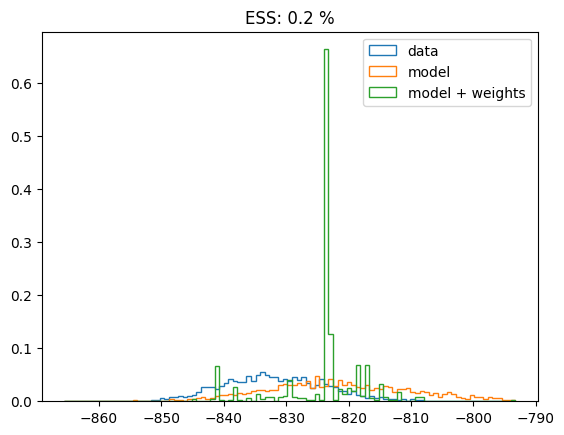

In [95]:
bins = jnp.linspace(
    U_data.min() - 10,
    U_data.max() + 10,
    100
)

plt.title(f"ESS: {ess * 100:.2} %")
plt.hist(np.array(U_data), bins=bins, histtype="step", density=True, label="data");
plt.hist(np.array(U_model), bins=bins, histtype="step", density=True, label="model");
plt.hist(np.array(U_model), bins=bins, histtype="step", weights=np.array(jnp.exp(log_weights)), density=True, label="model + weights");
plt.legend()
